# Finding the nuclei in divergent images to advance medical discovery

In [1]:
# Importing libraries 

import tensorflow as tf
import os
import numpy as np
from tqdm import tqdm
import random
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

In [2]:
np.random.seed = 16  # Set the random seed to ensure reproducibility of results

# Setting the image dimensions 
img_width = 128
img_height = 128
img_channels = 3

In [3]:
### Reading the data
train_path = 'Resources/data-science-bowl-2018/stage1_train/'
test_path = 'Resources/data-science-bowl-2018/stage1_test/'

In [4]:
train_ids = next(os.walk(train_path))[1] # Getting the list of the sub-folders
test_ids = next(os.walk(test_path))[1]

In [5]:
x_train = np.zeros((len(train_ids), img_width, img_height, img_channels), dtype=np.uint8)
y_train = np.zeros((len(train_ids), img_width, img_height, 1), dtype=bool)

In [7]:
# Resizing images and masks
print('Resizing images and masks')
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :img_channels]
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    x_train[n] = img  # Fill empty X_train with values from img
    mask = np.zeros((img_height, img_width, 1), dtype=bool)
    k = next(os.walk(path + '/masks/'))[2]
    for mask_file in k:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (img_height, img_width), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)

    y_train[n] = mask


Resizing images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 670/670 [03:02<00:00,  3.67it/s]


In [8]:
#Resizing Test images
x_test = np.zeros((len(test_ids), img_height, img_width, img_channels), dtype=np.uint8)
sizes_test = []
print('Resizing the test images')
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = test_path + id_
    img = imread(path + '/images/' + id_ + '.png')[:, :, :img_channels]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
    x_test[n] = img

print('Done!')

Resizing the test images


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:00<00:00, 65.31it/s]

Done!


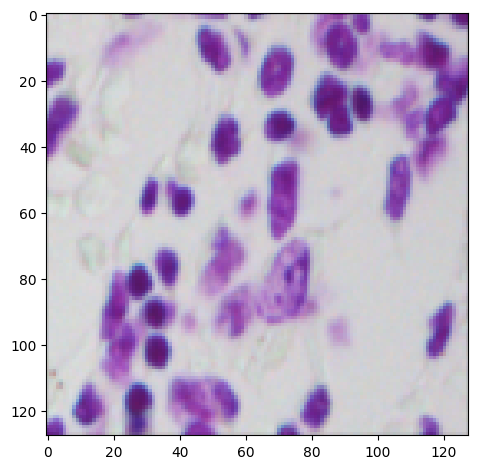

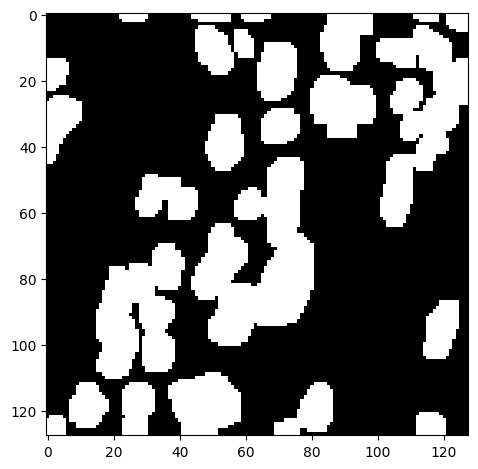

In [14]:
## Visualization

image_x = random.randint(0, len(train_ids))
imshow(x_train[image_x])
plt.show()
imshow(np.squeeze(y_train[image_x]))
plt.show()


In [15]:
# Buliding the moddel
inputs = tf.keras.Input((img_width, img_height, img_channels))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)  # Converting to floating points

In [16]:
# Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
# Kernel_initializer => initializing the weights values (normal distribution)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

In [17]:
### Expansive path
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [18]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [19]:
#### Model checkpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('Results/U-Net_segmentation.h5', verbose=1, save_best_only=True,
                                                  monitor='val_loss')
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
             tf.keras.callbacks.TensorBoard(log_dir='Results/logs'), checkpointer]

In [20]:
# Start Training
results = model.fit(x_train, y_train, validation_split=0.1, batch_size=16, epochs=25, callbacks=callbacks)

Epoch 1/25
38/38 [==============================] - ETA: 0s - loss: 0.6319 - accuracy: 0.7428
Epoch 1: val_loss improved from inf to 0.45032, saving model to Results\U-Net_segmentation.h5
38/38 [==============================] - 53s 1s/step - loss: 0.6319 - accuracy: 0.7428 - val_loss: 0.4503 - val_accuracy: 0.7749
Epoch 2/25
38/38 [==============================] - ETA: 0s - loss: 0.4097 - accuracy: 0.7597
Epoch 2: val_loss improved from 0.45032 to 0.27570, saving model to Results\U-Net_segmentation.h5
38/38 [==============================] - 40s 1s/step - loss: 0.4097 - accuracy: 0.7597 - val_loss: 0.2757 - val_accuracy: 0.8341
Epoch 3/25
38/38 [==============================] - ETA: 0s - loss: 0.2376 - accuracy: 0.9000
Epoch 3: val_loss improved from 0.27570 to 0.15494, saving model to Results\U-Net_segmentation.h5
38/38 [==============================] - 39s 1s/step - loss: 0.2376 - accuracy: 0.9000 - val_loss: 0.1549 - val_accuracy: 0.9346
Epoch 4/25
38/38 [=======================

## Testing

In [21]:
idx = random.randint(0, len(x_train))

pred_train = model.predict(x_train[:int(x_train.shape[0] * 0.9)], verbose=1)
pred_val = model.predict(x_train[int(x_train.shape[0] * 0.9):], verbose=1)
pred_test = model.predict(x_test, verbose=1)

pred_train_t = (pred_train > 0.5).astype(np.uint8)
pred_test_t = (pred_test > 0.5).astype(np.uint8)
pred_val_t = (pred_val > 0.5).astype(np.uint8)

3/3 [==============================] - 1s 139ms/step


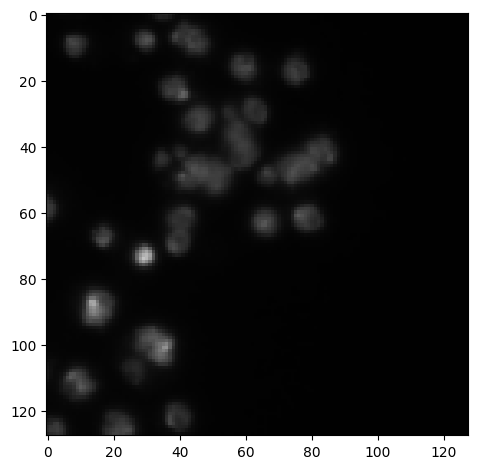

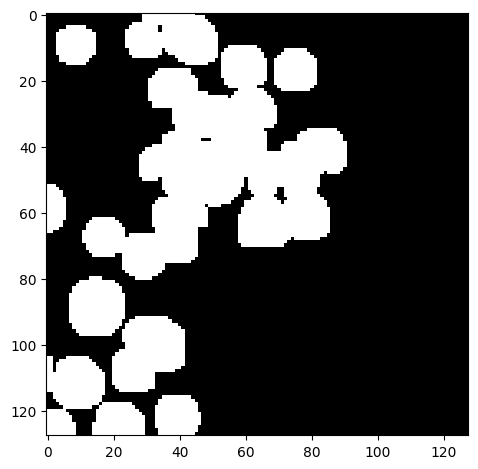

C:\Python311\Lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


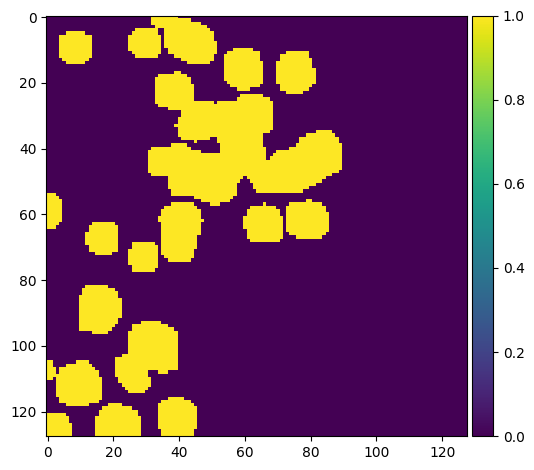

In [22]:
# Performing a sanity check on some random training samples

ix = random.randint(0, len(pred_train_t))
imshow(x_train[ix])
plt.show()
imshow(np.squeeze(y_train[ix]))
plt.show()
imshow(np.squeeze(pred_train_t[ix]))
plt.show()

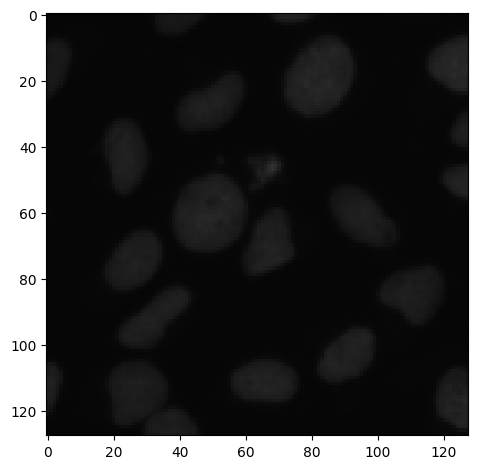

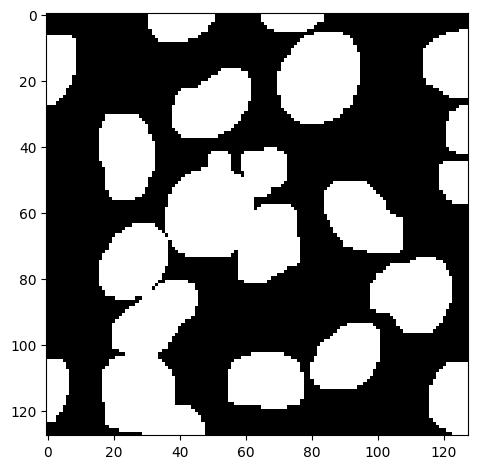

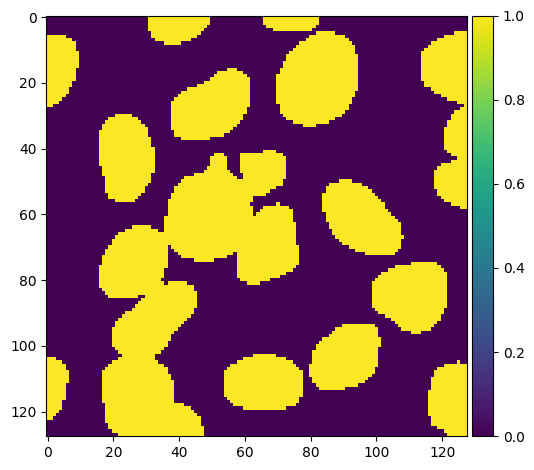

In [25]:
# Performing a sanity check on some random validation samples

ix = random.randint(0, len(pred_val_t))
imshow(x_train[int(x_train.shape[0] * 0.9):][ix])
plt.show()
imshow(np.squeeze(y_train[int(y_train.shape[0] * 0.9):][ix]))
plt.show()
imshow(np.squeeze(pred_val_t[ix]))
plt.show()

## Test visualization

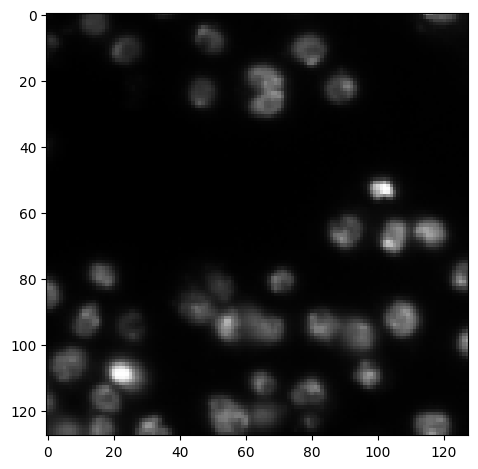

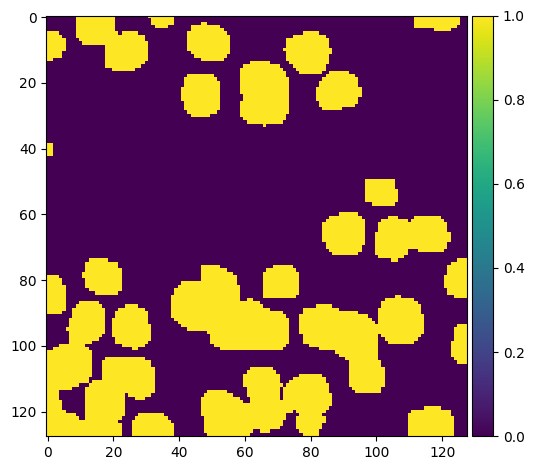

In [27]:
ix = random.randint(0, len(pred_val_t))
imshow(x_test[ix])
plt.show()
imshow(np.squeeze(pred_test_t[ix]))
plt.show()